In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LassoCV
import pingouin as pg
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
import sklearn.linear_model as skl_lm
from sklearn.linear_model import HuberRegressor

    calories    protein       fat     sodium      fibre     carbo     sugars  \
0  212.12121  12.121212  3.030303  393.93939  30.303030  15.15152  18.181818   
1  212.12121  12.121212  3.030303  787.87879  27.272727  21.21212  15.151515   
2  100.00000   8.000000  0.000000  280.00000  28.000000  16.00000   0.000000   
3  146.66667   2.666667  2.666667  240.00000   2.000000  14.00000  13.333333   
4  110.00000   2.000000  0.000000  125.00000   1.000000  11.00000  14.000000   

   potassium  
0  848.48485  
1  969.69697  
2  660.00000  
3   93.33333  
4   30.00000  


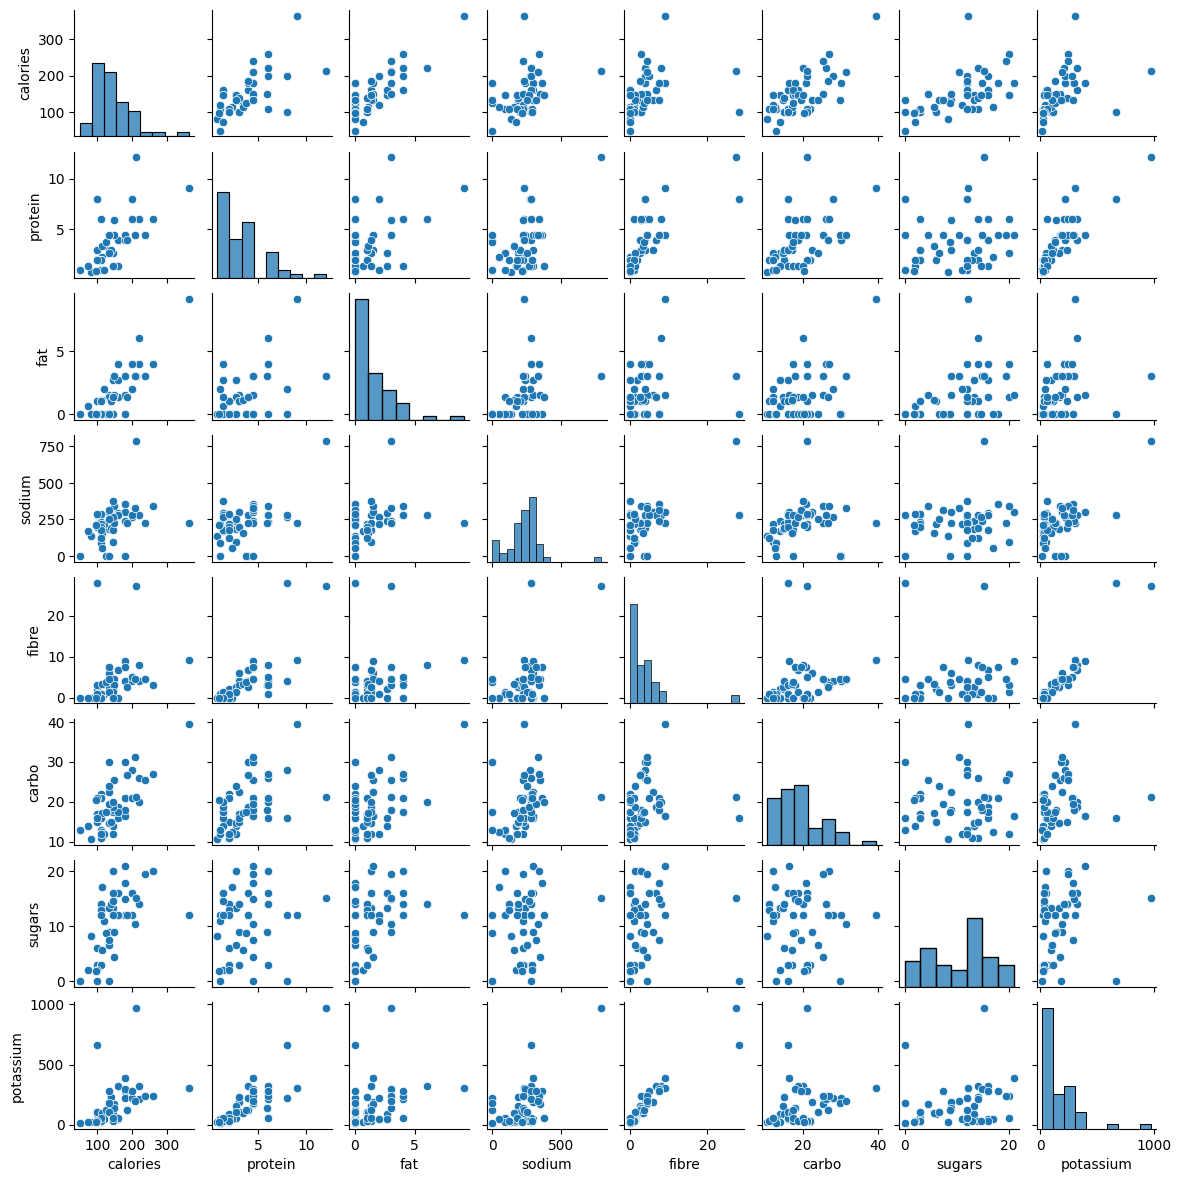

In [3]:
df = pd.read_csv('UScereal.csv')
print(df.head())

#Muestras train y test
X_train, X_test, y_train, y_test = train_test_split(
    df, df['calories'], test_size=0.2, random_state=42
)

sns.pairplot(X_train, height = 1.5)
plt.show()#grafico mosaico


In [4]:
# 2. Identificación del modelo

#En Python no he podido encontrar algoritmos iterativos de tipo forward, stepwise, backward o Fisher con AIC, BIC y tests de Fisher satisfactorios (sólo R^2 ajustado...).
#Vamos a proceder con correlaciones y correlaciones parciales y LASSO

# Correlación de Pearson
X_train.corr()
# Correlación de Spearman
X_train.corr(method="spearman")
# Correlación de Kendall
X_train.corr(method="kendall")

#correlaciones parciales
pg.partial_corr(data=X_train, x='protein', y='calories', covar=['fat','sodium','fibre','carbo','sugars','potassium'], method='spearman')
#protein eliminado del modelo

pg.partial_corr(data=X_train, x='fat', y='calories', covar=['protein','sodium','fibre','carbo','sugars','potassium'], method='spearman')
#fat se queda en el modelo

pg.partial_corr(data=X_train, x='sodium', y='calories', covar=['protein','fat','fibre','carbo','sugars','potassium'], method='spearman')
#sodium eliminado del modelo

pg.partial_corr(data=X_train, x='fibre', y='calories', covar=['protein','fat','sodium','carbo','sugars','potassium'], method='spearman')
#fibre eliminado del modelo

pg.partial_corr(data=X_train, x='carbo', y='calories', covar=['protein','fat','sodium','fibre','sugars','potassium'], method='spearman')
#carbo se queda en el modelo

pg.partial_corr(data=X_train, x='sugars', y='calories', covar=['protein','fat','sodium','fibre','carbo','potassium'], method='spearman')
#sugars se queda en el modelo

pg.partial_corr(data=X_train, x='potassium', y='calories', covar=['protein','fat','sodium','fibre','carbo','sugars'], method='spearman')
#potassium eliminado del modelo

#IMPORTANTE: Con PEARSON los RESULTADOS son DIFERENTES!! 
#casi todas las correlaciones parciales son significativas...
#esto viene probablemente de los outliers 

#Conclusion: Modelo identificado con las correlaciones, correlaciones parciales.
#Predictores: fat, carbo, sugars


,n,r,CI95%,p-val
spearman,52,0.105891,"[-0.19, 0.38]",0.483682


In [5]:
selec_pred = X_train.loc[:, ['fat','carbo','sugars']]

#Identificacion con LASSO
X_train_pred = X_train.drop(columns=['calories'])

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_pred, y_train)

# Get coefficients
coef = pd.Series(lasso.coef_, index=X_train_pred.columns)
coef

# Predictores seleccionados con Lasso
predictores = coef[abs(coef) > 0.1]
print("Predictores seleccionados con Lasso:")
print(predictores)

#Predictores eliminados con Lasso
n_predictores = coef[abs(coef) < 0.1]
print("Predictores eliminados con Lasso:")
print(n_predictores)

#Conclusion: Modelo identificado con LASSO.
#Predictores: protein, fat, carbo, sugars
    

Predictores seleccionados con Lasso:
protein    0.949430
fat        9.992409
carbo      4.564514
sugars     3.843570
dtype: float64
Predictores eliminados con Lasso:
sodium      -0.004428
fibre        0.000000
potassium    0.028822
dtype: float64


In [6]:
# 4. Estimación de los modelos de regresión lineal con los predictores seleccionados
#validacion de la colinealidad, outliers y otros puntos

# 4.1 Estimacion OLS del modelo seleccionado con LASSO
X_L = X_train_pred[list(predictores.index.tolist())]
X_const_L = sm.add_constant(X_L)
model_L = sm.OLS(y_train, X_const_L).fit()
print(model_L.summary())
#El test Omnibus es de la normalidad de los residuos.



                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     621.0
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           4.99e-40
Time:                        20:27:55   Log-Likelihood:                -176.92
No. Observations:                  52   AIC:                             363.8
Df Residuals:                      47   BIC:                             373.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5313      4.467     -0.791      0.4

In [7]:
#4.1.1 colinealidad
X_L.corr()

vif_data = pd.DataFrame()
vif_data["feature"] = X_L.columns
vif_data["VIF"] = [variance_inflation_factor(X_L.values, i) for i in range(X_L.shape[1])]
print(vif_data)



   feature       VIF
0  protein  5.292991
1      fat  2.554850
2    carbo  5.843042
3   sugars  3.498678


In [8]:
#4.1.2 outliers

#residuos estudentizados y influencia
infl = model_L.get_influence()
student = infl.summary_frame()["student_resid"]
print(student.loc[np.abs(student) > 2])

#leverages/efectos palenca
h_bar = 2 * (model_L.df_model + 1) / model_L.nobs
hat_diag = infl.summary_frame()["hat_diag"]
hat_diag.loc[hat_diag > h_bar]

#influencia
print(infl.summary_frame().loc[1])
print(infl.summary_frame().loc[2])
print(infl.summary_frame().loc[6])
print(infl.summary_frame().loc[31])

#conclusion: tenemos datos outliers e influyentes

6    -2.665400
31    4.607437
Name: student_resid, dtype: float64
dfb_const          0.023906
dfb_protein       -0.909302
dfb_fat            0.181478
dfb_carbo          0.334046
dfb_sugars        -0.061146
cooks_d            0.183116
standard_resid    -1.264773
hat_diag           0.364014
dffits_internal   -0.956859
student_resid     -1.273099
dffits            -0.963157
Name: 1, dtype: float64
dfb_const          0.308663
dfb_protein        0.628502
dfb_fat           -0.157649
dfb_carbo         -0.352591
dfb_sugars        -0.362109
cooks_d            0.112649
standard_resid     1.213282
hat_diag           0.276738
dffits_internal    0.750496
student_resid      1.219556
dffits             0.754377
Name: 2, dtype: float64
dfb_const          0.057273
dfb_protein        0.199784
dfb_fat           -0.002443
dfb_carbo         -0.258884
dfb_sugars         0.023206
cooks_d            0.040308
standard_resid    -2.507531
hat_diag           0.031057
dffits_internal   -0.448931
student_resid     

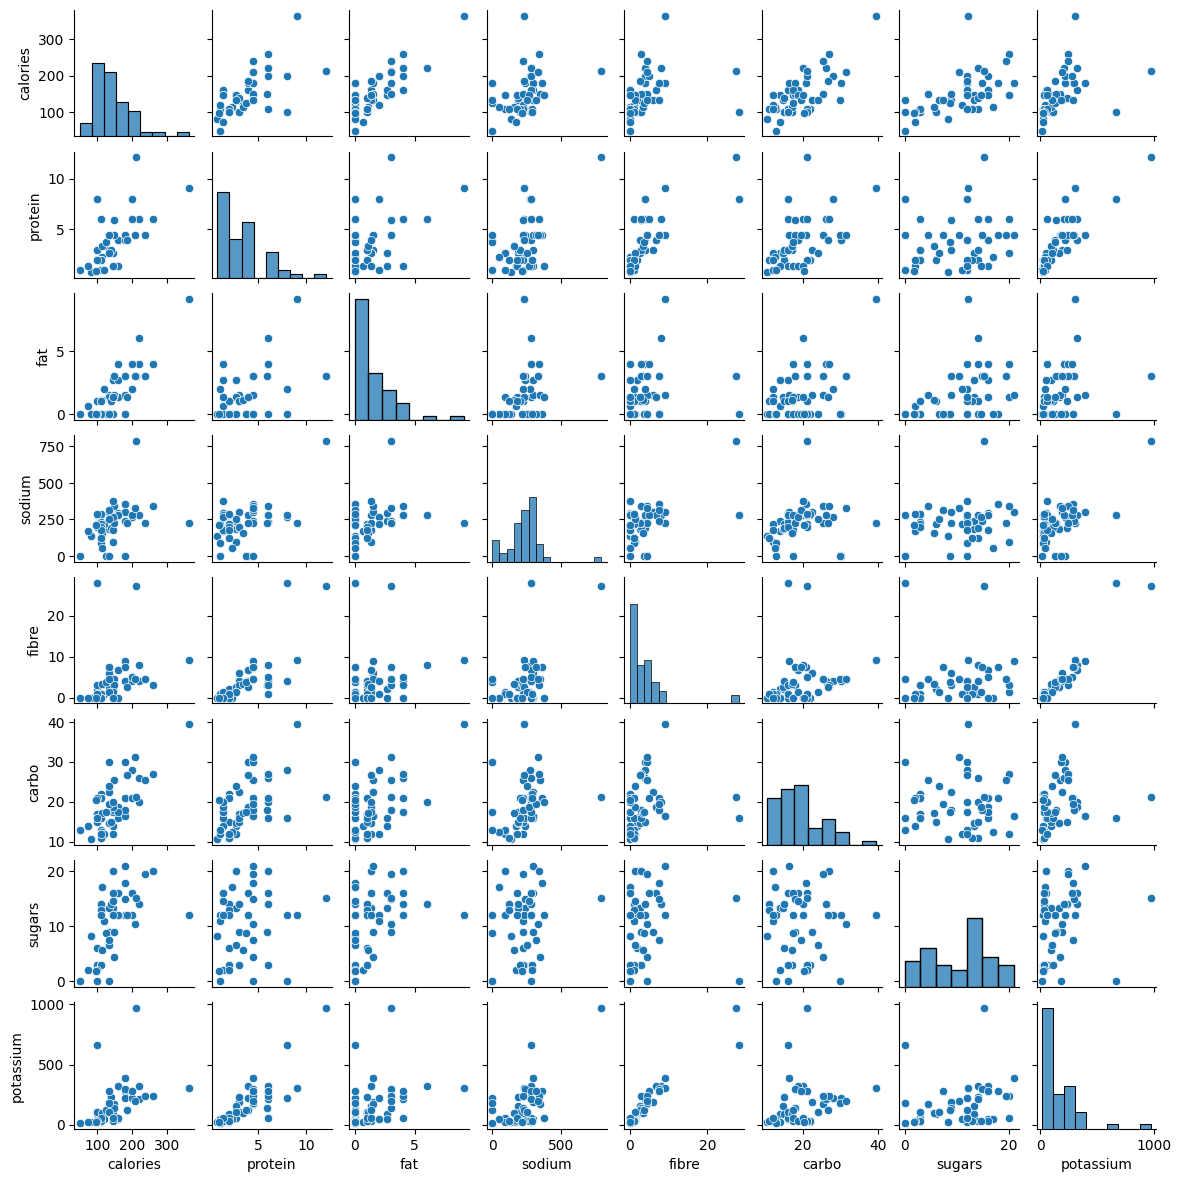

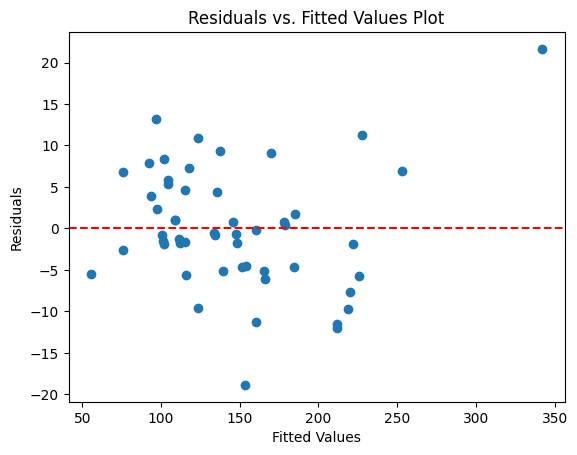

Breusch-Pagan test p-value: 0.0034246414072053254


In [9]:
#4.1.3 Análisis de heteroscedasticidad

sns.pairplot(X_train, height = 1.5)
plt.show()#grafico mosaico
#Comentario: no hay varianza creciente, son más puntos que se alejan

plt.scatter(model_L.fittedvalues, model_L.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()
#No hay forma de "trompeta", no hay falta de linealidad
#Hay puntos que se alejan---> mas un problema de outliers

#Test BP:
lm, lm_pvalue, fvalue, f_pvalue = sms.het_breuschpagan(model_L.resid, model_L.model.exog)
print(f'Breusch-Pagan test p-value: {lm_pvalue}')
#La hipótesis de homoscedasticidad es rechazada
#Sin embargo, parece que los datos se alejan mas 
#por outlier que por heteroscedasticidad


In [10]:
# 4.2 Estimacion OLS del modelo seleccionado con correlación parcial
X_const_r = sm.add_constant(selec_pred)
model_r = sm.OLS(y_train, X_const_r).fit()
print(model_r.summary())


                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     480.5
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           8.71e-36
Time:                        20:30:41   Log-Likelihood:                -191.25
No. Observations:                  52   AIC:                             390.5
Df Residuals:                      48   BIC:                             398.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9957      5.822     -0.686      0.4

In [ ]:
# 4.2.1 colinealidad
selec_pred.corr()

vif_data = pd.DataFrame()
vif_data["feature"] = selec_pred.columns
vif_data["VIF"] = [variance_inflation_factor(selec_pred.values, i) for i in range(selec_pred.shape[1])]
print(vif_data)

# VIF < 5, no hay colinealidad

  feature       VIF
0     fat  2.255456
1   carbo  3.452228
2  sugars  3.485230


In [20]:
# 4.2.2 outliers

#residuos estudentizados y influencia
print("Residuos estudentizados y influencia")
infl = model_r.get_influence()
student = infl.summary_frame()["student_resid"]
print(student.loc[np.abs(student) > 2])

#leverages/efectos palenca
print("Leverages/efectos palanca")
h_bar = 2 * (model_r.df_model + 1) / model_r.nobs
hat_diag = infl.summary_frame()["hat_diag"]
hat_diag.loc[hat_diag > h_bar]


#influencia
print
print(infl.summary_frame().loc[1])
print(infl.summary_frame().loc[2])
print(infl.summary_frame().loc[6])
print(infl.summary_frame().loc[17])
print(infl.summary_frame().loc[31])
print(infl.summary_frame().loc[50])
print(infl.summary_frame().loc[54])

#Conclusion: hay outliers influyentes también

Residuos estudentizados y influencia
6    -2.360213
56    2.857777
31    2.826833
2     3.151154
Name: student_resid, dtype: float64
Leverages/efectos palanca
dfb_const         -0.048046
dfb_fat            0.126442
dfb_carbo          0.015782
dfb_sugars         0.140364
cooks_d            0.034568
standard_resid     1.831954
hat_diag           0.039570
dffits_internal    0.371847
student_resid      1.879672
dffits             0.381533
Name: 1, dtype: float64
dfb_const          0.683517
dfb_fat            0.089261
dfb_carbo         -0.281434
dfb_sugars        -0.745027
cooks_d            0.193557
standard_resid     2.893481
hat_diag           0.084648
dffits_internal    0.879901
student_resid      3.151154
dffits             0.958259
Name: 2, dtype: float64
dfb_const          0.047461
dfb_fat            0.055177
dfb_carbo         -0.174584
dfb_sugars         0.031310
cooks_d            0.033426
standard_resid    -2.255279
hat_diag           0.025614
dffits_internal   -0.365654
student_r

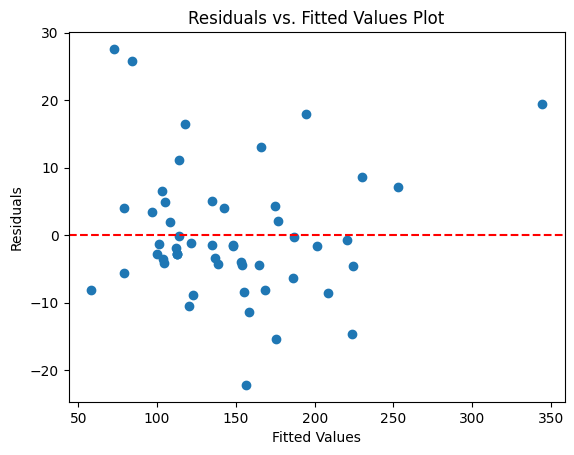

In [13]:
#4.2.3 Análisis de heteroscedasticidad

plt.scatter(model_r.fittedvalues, model_r.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()
#No hay forma de "trompeta", no hay falta de linealidad
#Hay puntos que se alejan---> mas un problema de outliers

In [14]:
#Test BP:
lm, lm_pvalue, fvalue, f_pvalue = sms.het_breuschpagan(model_r.resid, model_r.model.exog)
print(f'Breusch-Pagan test p-value: {lm_pvalue}')
#La hipótesis de homoscedasticidad NO es rechazada

Breusch-Pagan test p-value: 0.38490278599683075


In [15]:
# 4.3 Estimacion robusta del modelo seleccionado con LASSO (los dos consideran Huber)
model_L_R = sm.RLM(y_train, X_const_L).fit()
print(model_L_R.summary())

huber = HuberRegressor(epsilon=1.35) # Default epsilon
model_L_R2 =huber.fit(X_const_L, y_train)
print(f"HuberRegressor coefficients: {model_L_R2.coef_}")
print(f"HuberRegressor intercept: {model_L_R2.intercept_}")



                    Robust linear Model Regression Results                    
Dep. Variable:               calories   No. Observations:                   52
Model:                            RLM   Df Residuals:                       47
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 23 Jul 2025                                         
Time:                        20:35:53                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5827      3.793     -0.154      0.8

In [16]:
# 4.4 Estimacion robusta del modelo seleccionado con correlación parcial (los dos consideran Huber)
model_r_R = sm.RLM(y_train, X_const_r).fit()
print(model_r_R.summary())


model_r_R2 =huber.fit(X_const_r, y_train)
print(f"HuberRegressor coefficients: {model_r_R2.coef_}")
print(f"HuberRegressor intercept: {model_r_R2.intercept_}")

                    Robust linear Model Regression Results                    
Dep. Variable:               calories   No. Observations:                   52
Model:                            RLM   Df Residuals:                       48
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 23 Jul 2025                                         
Time:                        20:36:09                                         
No. Iterations:                    23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8620      4.469     -1.536      0.1

In [17]:
#5.1 validación ocupando el método K-fold (K=5)

scores_r = cross_val_score(model_r_R2, X_const_r, y_train, scoring='neg_mean_squared_error', cv=5)
print(f'MSE medio en validación cruzada: {-np.mean(scores_r):.2f}')

scores_L = cross_val_score(model_L_R2, X_const_L, y_train, scoring='neg_mean_squared_error', cv=5)
print(f'MSE medio en validación cruzada: {-np.mean(scores_L):.2f}')


MSE medio en validación cruzada: 117.44
MSE medio en validación cruzada: 83.66


In [18]:
#5.2 validación ocupando la muestra test

#Modelo seleccionado con LASSO
X_test_pred = X_test.drop(columns=['calories'])
X_L_test = X_test_pred[list(predictores.index.tolist())]
X_const_L_test = sm.add_constant(X_L_test)

pred = model_L_R.predict(X_const_L_test)
MSE = mean_squared_error(y_test, pred)   
print(MSE)


412.7003713737795


In [19]:
#Modelo seleccionado con correlación parcial
selec_pred_test= X_test.loc[:, ['fat','carbo','sugars']]
X_const_r_test = sm.add_constant(selec_pred_test)

pred = model_r_R.predict(X_const_r_test)
MSE = mean_squared_error(y_test, pred)   
print(MSE)

540.863526760482
